# Lab 10 : Expansion Rate of the Universe

## Objectives

The 2011 Nobel prize in physics was awarded to Saul Perlmutter, Brian P. Schmidt, and Adam G. Riess "*for the discovery of the accelerating expansion of the Universe through observations of distant supernovae*". **In this lab we will perform our own analysis of a compilation of supernova data.** As always there will be a few things we need to know before we look at the data.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.special as sf
import scipy.integrate as integ
import scipy.linalg as la

## Data

As noted in the prelab, the data we will use is from the Supernova Cosmology Project, in particular the Union 2.1 set. It is stored in a text file that you may access from its original site at
http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt

Note that we are working with the *real* data provided by the observers!  We can almost just read this file directly from the website using `loadtxt` similar to the technique from previous labs. In this case, however, the first column of the data file contains text, not just numbers, thus we cannot read the complete file into a NumPy array. If you look at this file you will see it contains five columns:
1. **first column  :** name of the supernova,
2. **second column :** redshift of the supernova ($z$),
3. **third column  :** distance modulus ($\mu$, see below for a discussion of this),
4. **fourth column :** uncertainty in the distance modulus, and
5. **fifth column  :** we will ignore.

As discussed in the prelab, we only need to read in the second through fourth columns.  Fortunately we can do this with `loadtxt` and it is sufficient to use it here. For actual work it would be far better to use [Pandas](https://pandas.pydata.org/) for reading in and processing data. This is a large, powerful package that we, unfortunately, do not have time to explore.

Read the data file and store the redshift, distance modulus, and the uncertainty in the distance modulus in arrays. We will use these arrays below. Note that the `unpack` keyword can be used to make unpacking the columns of data slightly easier and it is recommened that you use it.

In [2]:
url = "https://raw.githubusercontent.com/cwru-phys-250/p250-spring-2022/main/data/SCPUnion2.1_mu_vs_z.txt"
import urllib.request
with urllib.request.urlopen(url) as fp:
    z, mu, mu_unc = np.loadtxt(fp, usecols=(1,2,3), unpack=True)
p=z.argsort()
z=z[p]
mu=mu[p]
mu_unc=mu_unc[p]

## Cosmology

As we will discover, this data shows that the expansion rate of the Universe is accelerating. To do this we will fit for a few cosmological parameters. The relevant parameters are 
- $\Omega_{\mathrm{de}}$, the fraction of the total energy density in the Universe in the form of dark energy, 
- $w$, the "equation of state parameter" for dark energy, and 
- $h$, the reduced Hubble constant. 

The simplest form of dark energy has $w=-1$; this is called a cosmological constant. Dark energy has "negative pressure" and causes the expansion rate of the Universe to accelerate, thus a nonzero $\Omega_{\mathrm{de}}$ means we live in an accelerating universe (or more precisely, a universe that will have an accelerating expansion after some time). 

To discover the acceleration we need to relate these parameters to the observations from the data file. To further simplify things we will assume a flat universe. (In other words, no curvature, thus we are assuming the total $\Omega=1$, this will be enforced by hand in the equations below. Though a common assumption made, it is arguably not a statistically valid choice. See the end of the lab for more discussion.) The equations provided here are only valid for a flat universe. Describing distances in an expanding universe is not as simple as in Euclidean space so leads to more complicated looking equations. We will leave the details to a cosmology course, for our purposes we need to calculate the following quantities.
1. **Distance modulus:** The distance modulus, $\mu$, is a way of measuring the distance to an object in terms of its magnitude. It is given by
$$ \mu(z, \Omega_{\mathrm{de}}, w, h) = 5\log_{10}\!\!\left[ \frac{D_L(z, \Omega_{\mathrm{de}},w,h)}{10\,\mathrm{pc}} \right], $$
where $\mathrm{pc}$ stands for parsec, a unit of distance.
2. **Luminosity distance:** There are few distances we can define in an expanding universe, the one relevant for measuring how bright an object appears is the luminosity distance, $D_L$, and is given by 
$$ D_L(z, \Omega_{\mathrm{de}}, w, h) = (1+z) D_H(h) \int_0^z\frac{\mathrm{d}z'}{E(z', \Omega_{\mathrm{de}}, w)}.$$
Here
  1. $D_H$ is the Hubble distance, $D_H(h) = 3000 h^{-1} \,\mathrm{Mpc}$ where $1\,\mathrm{Mpc}=10^6\,\mathrm{pc} = 3.09\times10^{22} \,\mathrm{meters}$, and
  2. $E(z, \Omega_{\mathrm{de}}, w) = \sqrt{(1-\Omega_{\mathrm{de}})(1+z)^3 + \Omega_{\mathrm{de}} (1+z)^{3(1+w)}}$.

### Defining Functions

To proceed, we will need to implement the equations given above. I recommend you define each of the previous relationships as a separate function. There are a few things to keep in mind when doing so.
1. In the distance modulus the logarithm is base 10, not the natural logarithm. Recall that `np.log()` returns the natural logarithm.
2. If you define each of the above relationships in the "usual" way they will work for an array of redshift values, $z$, **except for the luminosity distance** due to the integral. For this reason I recommend defining a function `dl(z,Omega_de,w=-1.,h=0.7)` as given by the relationship above, then use `np.vectorize` to construct `DL`, as discussed in the prelab. Notice the order I have chosen for the arguments and the default values. This will be useful below and all your functions should be defined in a similar way.
3. Since we are integrating $1/E(z,\Omega_{\mathrm{de}},w)$ it makes sense to define a function that returns this inverted quantity instead of just $E(z,\Omega_{\mathrm{de}},w)$.
4. Be careful with units, make sure they are all consistent!

Keeping the above points in mind, define functions that will allow us to calculate the distance modulus for an array of redshift values. I recommend you define the distance modulus with default arguments as
```
def distance_modulus(z, Omega_de, w=-1.0, h=0.7):
```
and all other functions with appropriate defaults, as needed. This will be convenient in what follows.

In [3]:
def invE(z, Omega_de, w=-1.0):
    """ Helper function for quad to calculate 1/E for system, takes argument redshift data, Omega_de, dark energy fraction, and w, "equation of state parameter" for dark energy """
    return 1/(np.sqrt((1-Omega_de)*(1+z)**3 + Omega_de*(1+z)**(3*(1+w))))

def DH(h=0.7):
    """ Calculate Hubble's distance given reduced hubble constant """
    return (3000*1e6)/h

def dl(z, Omega_de, w=-1.0, h=0.7):
    """ Calculates luminosity distance base on redshift data and also takes   argument Omega_de, dark energy fraction, w, "equation of state parameter" for dark energy , and h, the reduced hubble constant"""
    integE= integ.quad(invE, 0, z, args=(Omega_de, w))[0]
    return (1+z)*DH(h)*integE

def distance_modules(z, Omega_de, w=-1.0, h=0.7):
    """ This function calculates the distance modules base on of a set of redshift data z. It also takes argument Omega_de, dark energy fraction, w, "equation of state parameter" for dark energy , and h, the reduced hubble constant"""
    DL= np.vectorize(dl)
    return 5*np.log10(DL(z, Omega_de, w, h)/10)

## Sample Models

The $\chi^2$ is not just for fitting, it can also be used test models as discussed in the prelab. Here we will consider a few models and test their goodness of fit (find their $p$-values).

**For each of these sets of parameters calculate the $\chi^2$ between the model and the Union data set. Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit.**

*Hint:* Recall that when we calculate the number of degrees of freedom we need to know the number of parameters being fit. Here there is **no fitting** being performed so what do we mean by the number of degrees of freedom?

##### Matter Dominated

In a matter dominated universe there is no dark energy so $\Omega_{\mathrm{de}}=0$. Further, let $h=0.7$. Since we are assuming a flat universe, if $\Omega_{\mathrm{de}}=0$ then the only other non-neglible component of the universe is matter and we are really considering model with $\Omega_m=1$ (which is ruled out by other observations, but this is just a test model). Also, since there is no dark energy the value of the $w$ is irrelevant, its value does not enter affect the calculation at all.

In [4]:
md_mu= distance_modules(z, Omega_de=0)

chi_2 = np.sum(((mu - md_mu) / mu_unc)**2)
dof = len(mu) 
Q = sf.gammaincc(0.5*dof, 0.5*chi_2)
print("Chi Squared:", chi_2)
print("Degrees of Freedom:", dof)
print("Goodness of Fit:", Q)


Chi Squared: 2123.090528457671
Degrees of Freedom: 580
Goodness of Fit: 1.962233248049933e-174


##### Einstein-deSitter

An Einstein-deSitter universe is the opposite of a matter dominated one; all the energy in the universe is a cosmological constant. Use the parameters $\Omega_{\mathrm{de}}=1$, $w=-1$, and $h=0.7$. (Of course this model also has problems since $\Omega_m=0$, i.e., there is no matter in such a universe, which clearly is not consistent with our Universe!)

In [5]:
mu_ed= distance_modules(z, Omega_de=1)

chi_2 = np.sum(((mu - mu_ed) / mu_unc)**2)
dof = len(mu) 
Q = sf.gammaincc(0.5*dof, 0.5*chi_2)
print("Chi Squared:", chi_2)
print("Degrees of Freedom:", dof)
print("Goodness of Fit:", Q)

Chi Squared: 1314.129649170134
Degrees of Freedom: 580
Goodness of Fit: 7.275776412364852e-59


##### CMB (Planck Data Release 3)

The fluctuations in the cosmic microwave background (CMB) provide one of the best probes of the fundamental cosmological parameters. The current best observations of the full-sky CMB is from the Planck satellite. One set of parameters derived from their data is $\Omega_{\mathrm{de}}=0.6853$, $w=-1$ (assumed for this fit), and $h=0.6732$. A number of simplifications have been made here, see their [Cosmological Parameters paper](https://arxiv.org/abs/1807.06209) for details. These values are extracted from Table 1.

*Note:* You should find this is a much better fit than the previous two models, but still not a great one. This suggests there may still be some tension between the CMB and supernova data. This "tension" has persisted for a number of years and is an ongoing area of research to understand if it is real and what it would mean.

In [6]:
mu_cmb= distance_modules(z, Omega_de=0.6853, w=-1, h=0.6732)

chi_2 = np.sum(((mu - mu_cmb) / mu_unc)**2)
dof = len(mu) 
Q = sf.gammaincc(0.5*dof, 0.5*chi_2)
print("Chi Squared:", chi_2)
print("Degrees of Freedom:", dof)
print("Goodness of Fit:", Q)

Chi Squared: 665.7229577287347
Degrees of Freedom: 580
Goodness of Fit: 0.0077184877135666055


## Parameter Fits

We can also fit for the best values of the cosmological parameters, $\Omega_{\mathrm{de}}$, $w$, and $h$. We will do this by first fitting for one parameter, then two, then all of them. At each step we should see the value of the $\chi^2$ decreases (at least by a little) but this does **not** necessarily mean that we have a better fit as shown by the goodness of fit.  In other words, the data may not justify adding more parameters to the model.

To get some idea of the expected results, the best fit values from the Supernova Cosmology Project and other cosmological observations are $\Omega_{\mathrm{de}}=0.729 \pm 0.014$ and $w=-1.013 (+0.068/-0.073)$. They do not quote a value for the Hubble constant, $h$, but it is expected to be around $0.7$. These results come from a much more sophisticated analysis than we will perform, does not rely on the assumption of Gaussian errors, and includes both statistical and systematic errors. We will not find exactly the same results but they should be similar. (You can learn the very gory details from their [paper](http://arxiv.org/abs/1105.3470). On going observations, particularly by the SH0ES project, continues to refine these values and they continue to deviate from those derived from the CMB.)

##### Fit for $\Omega_{\mathrm{de}}$:

Fix $w=-1$ and $h=0.7$. Fit for $\Omega_{\mathrm{de}}$. Print the best fit value for $\Omega_{\mathrm{de}}$, its uncertainty, the $\chi^2$ for the fit, the number of degrees of freedom, and the goodness of fit.

In [7]:
(p_omega, C) = opt.curve_fit(distance_modules, z, mu, sigma=mu_unc, p0=0.729, absolute_sigma=True)
unc= np.sqrt(np.diag(C))

chi_2= np.sum(((mu - distance_modules(z, *p_omega)) / (mu_unc)) ** 2)
dof= len(mu)- len(p_omega)
Q = sf.gammaincc(0.5*dof, 0.5*chi_2)

print("Omega_de:", p_omega[0], "+/-", unc[0])

print("Chi Square:", chi_2)
print("Degrees of Freedom:", dof)
print("Goodness of Fit:", Q)


Omega_de: 0.7202493773129266 +/- 0.013220122843168423
Chi Square: 562.2487721466182
Degrees of Freedom: 579
Goodness of Fit: 0.6834778371981393


##### Fit for $\Omega_{\mathrm{de}}$ and $w$:

Fix $h=0.7$.  Fit for $\Omega_{\mathrm{de}}$ and $w$. Print the best fit values for $\Omega_{\mathrm{de}}$ and $w$, their uncertainties, the $\chi^2$ for the fit, the number of degrees of freedom, and the goodness of fit.

In [8]:
(p1, C) = opt.curve_fit(distance_modules, z, mu, sigma=mu_unc, p0=np.array([0.729, -1.013]), absolute_sigma=True)
unc= np.sqrt(np.diag(C))

chi_21= np.sum(((mu - distance_modules(z, *p1)) / (mu_unc)) ** 2)
dof1= len(mu)- len(p1)
Q1 = sf.gammaincc(0.5*dof1, 0.5*chi_21)

print("Omega_de:", p1[0], "+/-", unc[0])
print("w:", p1[1], "+/-", unc[1])
print("Chi Square:", chi_21)
print("Degrees of Freedom:", dof1)
print("Goodness of Fit:", Q1)


Omega_de: 0.7244622826328618 +/- 0.06480973165629571
w: -0.9902894254515077 +/- 0.1448680465456619
Chi Square: 562.2443308265108
Degrees of Freedom: 578
Goodness of Fit: 0.6729329715499431


##### Fit for $\Omega_{\mathrm{de}}$, $w$, and $h$:

Fit for $\Omega_{\mathrm{de}}$, $w$, and $h$. Print the best fit values for $\Omega_{\mathrm{de}}$, $w$, and $h$, their uncertainties, the $\chi^2$ for the fit, the number of degrees of freedom, and the goodness of fit.

In [9]:
(p2, C) = opt.curve_fit(distance_modules, z, mu, sigma=mu_unc, p0=np.array([0.729, -1.013, 0.7]), absolute_sigma=True)
unc= np.sqrt(np.diag(C))

chi_22= np.sum(((mu - distance_modules(z, *p2)) / (mu_unc)) ** 2)
dof2= len(mu)- len(p2)
Q2 = sf.gammaincc(0.5*dof2, 0.5*chi_22)

print("Omega_de:", p2[0], "+/-", unc[0])
print("w:", p2[1], "+/-", unc[1])
print("h:", p2[2], "+/-", unc[2])
print("Chi Square:", chi_22)
print("Degrees of Freedom:", dof2)
print("Goodness of Fit:", Q2)


Omega_de: 0.7188337373166439 +/- 0.07377413446946328
w: -1.0098976557814698 +/- 0.20023656315024596
h: 0.7006686140757565 +/- 0.004706279183804057
Chi Square: 562.2242102136402
Degrees of Freedom: 577
Goodness of Fit: 0.6624135231943113


## Figure

Let us put all the results together into a single figure. Plot the data with error bars using `errorbar`. Include lines for the matter dominated and Einstein-deSitter models from above. You should see by eye that these models do not fit the data well.  Include a line from one of the best fit models. (In the final figure do not include the Planck model nor all of the fits as these lines should be indistinguishable.  Feel free to verify this.)

Text(0, 0.5, 'Distance Modulus (parsecs)')

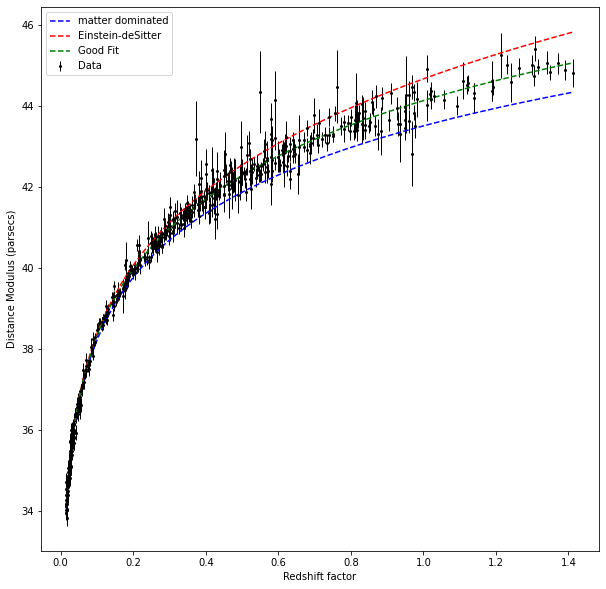

In [10]:


xfine = np.linspace(0, 3 * np.pi, 100)
plt.figure(figsize=(10, 10))
plt.errorbar(z, mu, yerr=mu_unc, fmt='ko', markersize=2, elinewidth=1, label='Data')
plt.plot(z, md_mu, 'b--', label='matter dominated')
plt.plot(z, mu_ed, 'r--', label='Einstein-deSitter')
plt.plot(z, distance_modules(z, *p2), 'g--', label='Good Fit')
plt.legend()
plt.xlabel("Redshift factor")
plt.ylabel("Distance Modulus (parsecs)")

Based on the results and figure from above, explain why the awarding of the Nobel prize was justified, that is, why the supernova data requires the expansion rate of our Universe to be accelerating.

Since $\Omega_{de}$ is a nonzero value in the best fit, the universe must be expanding at an increasing rate. If it was not accelerating, that data should have had a better fit with the matter dominated. But $\Omega_{de}$ must be less then 1 as show by Einstein deSitters model, showing that the acceleration is not at the rate predicted by that model.

## A Flat Universe?

Does it make sense to assume the Universe is flat, that is, can we fix $\Omega=1$? It is something that is typically done. In fact, the "standard cosmological model" is a 6 parameter model that assumes a flat Universe! Despite this, forcing $\Omega=1$ is a questionable action. Although topology can provide models that must be flat (certain topologies only allow for flat spacetimes), even in these cases we do not expect our observations over a finite region of the Universe to exactly have $\Omega=1$. It would only be exactly flat if we could measure the entire Universe. Thus it makes much more sense to also keep $\Omega$ as a free parameter in our fit. This can be done in a way similar to what we have done in this lab; it requires known modifications to the equations we have used. Interestingly, when doing so with CMB data from Planck, the preferred value of the Hubble constant comes out even lower!

## Member Participation

See Lab00 for instructions on turning in labs. We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab. Again, see Lab00 for more details. It is expected that you have read and understood those details.